# Modelling 12 Technical Indicators With Machine Learning Predictions

Ref: [CodeTraining video: "Technical Indicators Comparison Using Machine Learning In Python"](https://www.youtube.com/watch?v=tNFnACpzxVw&list=PLwEOixRFAUxZO-WTGS1rJ4ijvkUePWg_-&index=5)

In [40]:
import sys
import pandas as pd
from dotenv import load_dotenv

sys.path.append("..")

from src.utils.constants import STOCKS_CURATED_TABLE_NAME
from src.utils.stock_duck_db_conn import StockDuckDbConn

load_dotenv("../config/.env")

ticker = "NVDA"

df: pd.DataFrame = None
with StockDuckDbConn().get_current_conn() as conn:
    df = conn.sql(f"""
        SELECT * FROM {STOCKS_CURATED_TABLE_NAME}
        WHERE ticker = ?
    """, params=[ticker]).to_df()

#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
# df.isna().sum()
# df.tail()

In [ ]:
#Target flexible way
pipdiff = 200*1e-1 #for TP - amended for this dataset TODO check if correct
SLTPRatio = 2 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

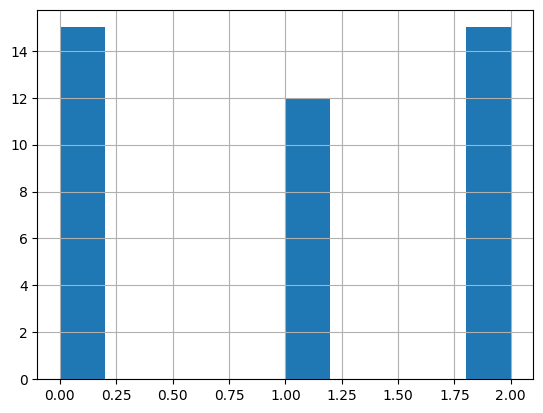

In [42]:
df['Target'] = mytarget(20, df)
df['Target'].hist() # TODO added matplotlib via UV for this to work
#df.tail(20)
#df['Target'] = df['Target'].astype(int)

In [43]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

,ticker,date,open,high,low,close,volume,RSI,CCI,AO,...,DMP_16,DMN_16,STOCHk_14_3_3,STOCHd_14_3_3,STOCHh_14_3_3,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,WPR,load_time,Target
26,NVDA,2025-11-17,185.959645,188.989475,184.309743,186.589615,173628900,47.604135,-1840.033798,-0.740665,...,1.646494,2.202177,26.943075,32.749034,-5.805959,3.437836,7.611105,-76.893049,2025-12-26 23:20:47.551311,0.0
27,NVDA,2025-11-18,183.369791,184.789710,179.639988,181.349899,213598900,43.669945,-1681.689207,-2.855930,...,1.543588,2.356400,21.498579,27.532090,-6.033511,3.437836,5.283347,-92.638264,2025-12-26 23:20:47.551311,0.0
28,NVDA,2025-11-19,184.779698,187.849535,182.819816,186.509613,247246400,48.169244,-1599.884885,-4.365024,...,1.638353,2.209125,18.042514,22.161389,-4.118875,4.916426,3.930699,-77.133453,2025-12-26 23:20:47.551311,1.0
29,NVDA,2025-11-20,195.939089,195.989089,179.839995,180.629944,343504800,43.906498,-1727.740713,-4.310645,...,2.044678,2.071055,12.118376,17.219823,-5.101447,5.425144,4.593135,-94.665461,2025-12-26 23:20:47.551311,0.0
30,NVDA,2025-11-21,181.229910,184.549717,172.920360,178.870041,346926200,42.700039,-1707.685446,-5.528372,...,1.916886,2.374091,15.989761,15.383550,0.606210,5.425144,5.255571,-84.509213,2025-12-26 23:20:47.551311,0.0


In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'CCI', 'AO', 'MOM', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATR',
       'BOP', 'RVI', 'DMP_16', 'DMN_16', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'WPR']

attributes = ['MACDs_12_26_9', 'ATR', 'DMP_16']

X = df[attributes]
y = df['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 40.0000%


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[ 3  0  0]
 [ 0  8  0]
 [ 0  0 10]]
[[0 6]
 [0 4]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.40      1.00      0.57         4

    accuracy                           0.40        10
   macro avg       0.20      0.50      0.29        10
weighted avg       0.16      0.40      0.23        10

['MACDs_12_26_9', 'ATR', 'DMP_16']


/home/hari/repos/quant-predictive-analysis/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hari/repos/quant-predictive-analysis/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hari/repos/quant-predictive-analysis/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


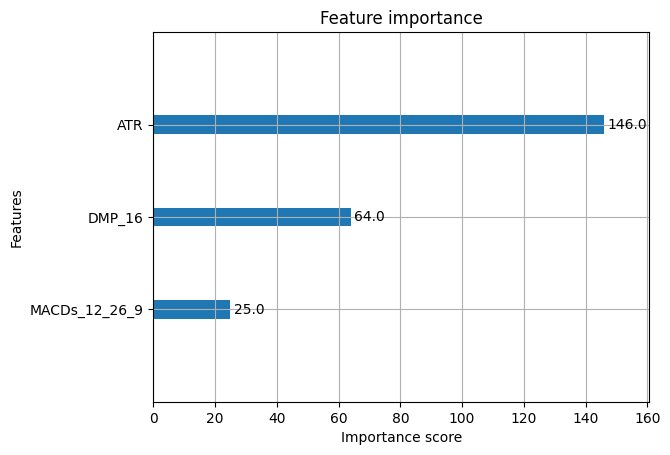

['MACDs_12_26_9', 'ATR', 'DMP_16']


In [46]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)